# Análise exploratória dos danos do ENEM 2019


Esse é um projeto guiado para iniciantes fornecido pela [Alura](https://www.alura.com.br/).<br><br>

Nesse projeto, estamos trabalhando com dados do Exame Nacional do Ensino Médio (ENEM) do ano 2019. O [ENEM](https://enem.inep.gov.br/) é um exame nacional utilizado como prova padrão para admissão de diverssas universidades federais, estaduais e até particulares.

O banco de dados completo é bem grande (>3 Gb).<br>
Nesse sentido, vamos trabalhar com uma amostra extraída de forma aleatória, disponível no [GitHub do guilhermesilveira](https://github.com/alura-cursos/imersao-dados-2-2020).<br>

Os dados completos, bem como outras informações podem ser encontradas no [site do INEP](http://inep.gov.br/web/guest/microdados)

#### Importando alguns módulos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Lendo a nossa amostra
O '43278' no final do nome do arquivo é a seed usada para gerar a amostra.

In [2]:
dados = pd.read_csv('MICRODADOS_ENEM_2019_SAMPLE_43278.csv')
dados.head(2)

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,...,A,A,A,A,B,A,C,A,B,B
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,...,A,A,A,B,A,A,B,A,A,B


## Qual é a UF de residência dos participantes com 14 anos de idade ou menos?

In [3]:
fourteen = dados.query('NU_IDADE <= 14')['SG_UF_RESIDENCIA'].value_counts()
print("\n", 'Na nossa amostra, o estado com mais participantes com 14 anos ou menos foi', fourteen.idxmax())


 Na nossa amostra, o estado com mais participantes com 14 anos ou menos foi PE


#### Vamos conferir a distribuição desses participantes

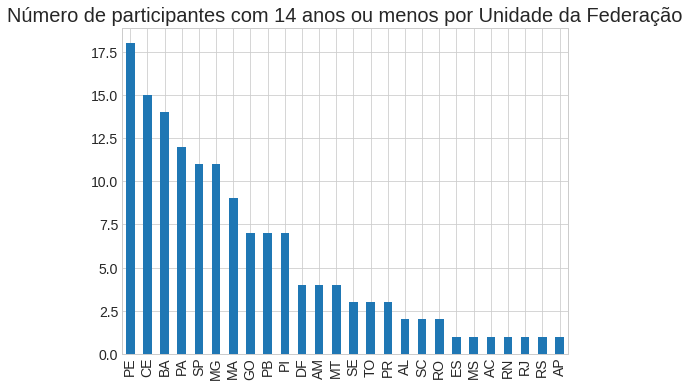

In [4]:
plt.style.use('seaborn-whitegrid')
fourteen.plot.bar(figsize = (8,6))
plt.title('Número de participantes com 14 anos ou menos por Unidade da Federação', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

**OBS:** É importante ressaltar que essas informações podem não se confirmar se utilizarmos o dataset completo. Adicionalmente, a plotagem de um gŕafico usando valores em forma de proporção não seria tão interessante, já que o N de participantes é pequeno na nossa amostra

##### Vamos confirmar as informações do gráfico acima, usando o dataset  completo

Como o dataset é muito grande, utilizei AWK para filtrar o arquivo sem carregá-lo no Jupyter:<br>
`awk -F ";" '{ if($7 <= 14) {print}}' MICRODADOS_ENEM_2019.csv > sample.csv`

In [5]:
sample = pd.read_csv('./microdados_enem_2019/DADOS/fourteen_or_less.csv', sep=';', encoding='ISO-8859-1')

In [6]:
print(sorted(sample['NU_IDADE'].unique()), '\n')
print(sample['NU_IDADE'].value_counts().sort_index())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

1        2
2        4
3        4
4        2
5        5
6        9
7       15
8       25
9        3
10       6
11       9
12      46
13     266
14    5267
Name: NU_IDADE, dtype: int64


Estranhamente, temos participantes com idades bastante baixas. Talvez tenha sido um erro na coleta ou preenchimento dos dados.<br>
Porém, podemos notar que a frequência de participantes com idades mais baixas é pequena, com exceção para '7' e '8'.

##### Sobre o uso da paleta de cores adequada:

A escolha da paleta de cores é uma parte importante do "Data Visualization". Mesmo que cada um tenha uma opinião pessoal sobre qual paleta faz um gráfico mais "bonito", existem áreas de pesquisa focadas nesse assunto. Esse tipo de conclusão envolve conceitos físicos, psicológicos e até neurociência.
Nesse caso, sempre que possível, é importante trabalhar com uma paleta que seja uniforme e permita rápida diferenciação, **até mesmo para pessoas com daltonismo**.
Nesse sentido, escolhi a 'viridis'.

**Para saber mais:**
Mais informações disponíveis no link [Paleta de cores](#paleta_de_cores) ou no final deste notebook!.
<br> 



In [7]:
# Criei aqui uma função para facilitar a plotagem de countplots futuros
def func_countplot(eixo_x, dataframe, ordem, titulo, ylabel, xlabel):
    sns.set(style="ticks", font_scale=1.5, font='FreeSans')
    sns.countplot(x=eixo_x, data=dataframe, order=ordem, palette='viridis')
    plt.title(titulo, weight='bold')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

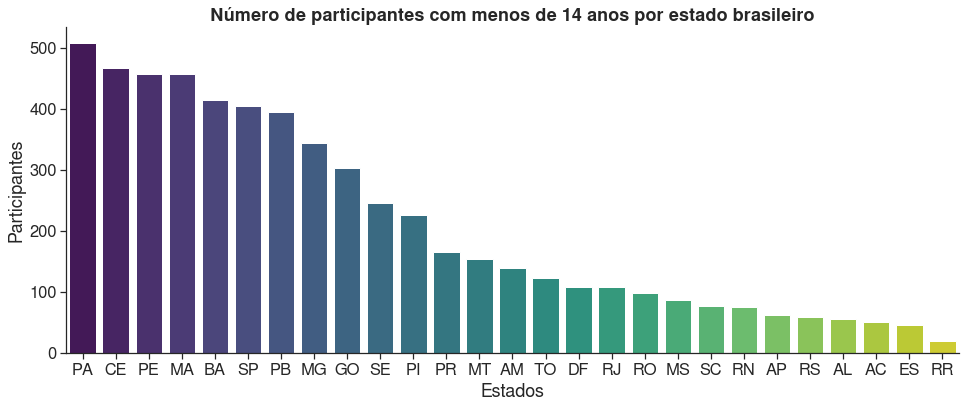

In [8]:
plt.figure(figsize=(16,6))
func_countplot(sample['SG_UF_RESIDENCIA'], sample, sample['SG_UF_RESIDENCIA'].value_counts().index, 'Número de participantes com menos de 14 anos por estado brasileiro'
               ,'Participantes', 'Estados')

sns.despine();

Aqui, onde foi utilizado o dataset completo, podemos notar como estados do Norte e Nordeste lideram no número total de inscritos com baixa idade. SP e MG estão próximos, porém estes são os dois estados mais populosos do Brasil. <br>
[Fonte: IBGE](https://www.ibge.gov.br/cidades-e-estados)

### Se levarmos em consideração o tamanho da população em cada estado, a posição de SP e MG mudará no ranking?

Para fazer essa análise, busquei no site do IBGE a população de cada UF brasileira **estimada** para 2020. Criei um dicionário armazenando essas informações. Em seguida criei um dataframe armazenando o a população total de cada estado, número de participantes com 14 anos ou menos e qual seria o número ajustado de participantes para cada 10.000 habitantes.<br>
[Fonte: IBGE](https://www.ibge.gov.br/cidades-e-estados)

In [9]:
fourteen_count = sample.groupby('SG_UF_RESIDENCIA').count()['NU_INSCRICAO']

dicio = {'AC': 894470, 'AL': 3351543, 'AP': 861773, 'AM': 4207714, 'BA': 14930634, 'CE': 9187103, 'DF': 3055149, 
         'ES': 4064052, 'GO': 7113540, 'MA': 7114598, 'MT': 3526220, 'MS': 2809394, 'MG': 21292666, 'PR': 11516840,
         'PB': 4039277, 'PA': 8690475, 'PE': 9616621, 'PI': 3281480, 'RN': 3534165, 'RS': 11422973, 'RJ': 17366189,
         'RO': 1796460, 'RR': 631181, 'SC': 7252502, 'SE': 2318822, 'SP': 46289333, 'TO': 1590248}
df = pd.DataFrame.from_dict(dicio, orient='index', columns=['populacao_2020'])

In [10]:
df['participantes'] = fourteen_count
df['participantes/10.000'] = df['participantes'] / df['populacao_2020'] * 10000
df.head()

,populacao_2020,participantes,participantes/10.000
AC,894470,51,0.570170
AL,3351543,56,0.167087
AP,861773,62,0.719447
AM,4207714,139,0.330346
BA,14930634,415,0.277952


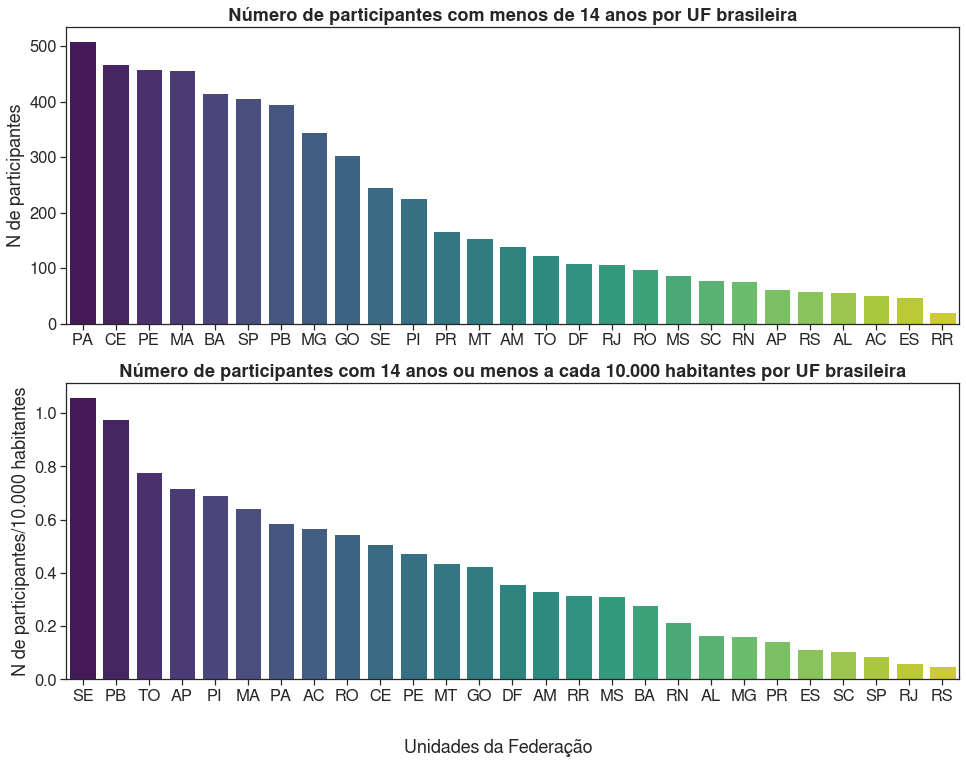

In [11]:
sns.set(style="ticks", font_scale=1.5, font='FreeSans')


fig, axes = plt.subplots(2, 1, figsize=(16,12))

# <= 14 anos
sns.countplot(ax= axes[0], x=sample['SG_UF_RESIDENCIA'], data=sample, 
              order=sample['SG_UF_RESIDENCIA'].value_counts().index, palette='viridis')
axes[0].set_title('Número de participantes com menos de 14 anos por UF brasileira',weight ='bold')
axes[0].set_xlabel('')
axes[0].set_xlabel('')
axes[0].set_ylabel('N de participantes')


# <= 14 anos ajustado/10.000 hab

sns.barplot(x=df.index, y="participantes/10.000", data=df, 
            order=df['participantes/10.000'].sort_values(ascending=False).index, palette='viridis')
axes[1].set_title('Número de participantes com 14 anos ou menos a cada 10.000 habitantes por UF brasileira', weight='bold')
axes[1].set_ylabel('N de participantes/10.000 habitantes')

fig.text(0.5, 0.04, 'Unidades da Federação', ha='center');

Corrigindo o número de participantes <= 14 anos pela população, vemos que SP e MG são alocados para o final do gráfico e os estados do Nordeste/Norte continuam nos primeiros lugares.<br>
**Obs**: é importante ressaltar que outros ajustes seriam necessários pra uma comparação mais justa, como por exemplo considerar a idade média da população de cada UF.

## A renda familiar impacta o rendimento geral dos participantes?

In [12]:
# Q006 é uma variável que estratifica a renda familiar média. Mais informações podem ser visualizadas no 
# dicionário de dados. 
# Aqui eu criei uma lista para manter as classificações de modo ordenado.
renda_ordenada = dados['Q006'].unique()
renda_ordenada.sort()
renda_ordenada

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q'], dtype=object)

Vamos plotar um Box Plot para verificar essa relação

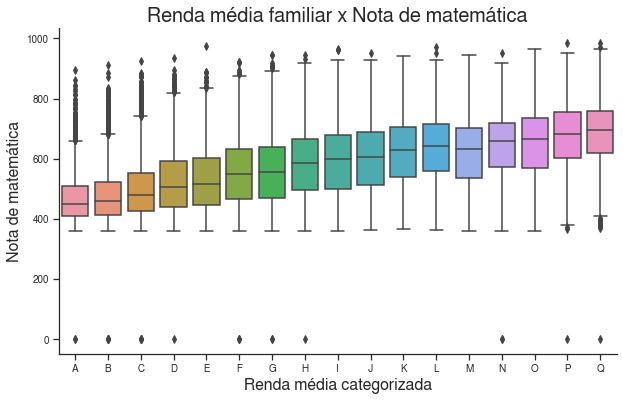

In [13]:
sns.set(style="ticks", font_scale=1.5, font='FreeSans')

plt.figure(figsize=(10,6))
sns.boxplot(x='Q006', y='NU_NOTA_MT', data=dados, order=renda_ordenada)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Nota de matemática', fontsize=16)
plt.xlabel('Renda média categorizada', fontsize=16)
sns.despine()
plt.title('Renda média familiar x Nota de matemática', fontsize=20);

A figura acima nos mostra brevemente que a média nos scores de matemática('NU_NOTA_MT') parecem aumentar enquanto a renda média ('Q006') também aumenta.

Também podemos notar como os resultados parecem estar mais concentrados perto da média, mostrando menor variação nas notas à medida que a renda aumenta.

### Agora, vamos focar no Score total obtido pelos participantes

Aqui, adicionei uma nova variável ao dataframe chamada 'NU_NOTA_TOTAL' (seguindo a nomenclatura do banco), somando os scores dos outros testes 

In [14]:
provas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']
dados['NU_NOTA_TOTAL'] = dados[provas].sum(axis=1)
dados.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_TOTAL
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,...,A,A,A,B,A,C,A,B,B,2288.9
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,...,A,A,B,A,A,B,A,A,B,1184.6
2,190001004722,2019,1501402,Belém,15,PA,35,F,2,1,...,A,A,B,A,B,B,A,A,B,2350.5
3,190001004735,2019,1507300,São Félix do Xingu,15,PA,23,F,1,3,...,A,A,B,A,A,B,A,A,B,2555.7
4,190001004776,2019,1500800,Ananindeua,15,PA,16,F,1,3,...,A,A,B,A,A,D,A,A,B,2803.5


##### Desafio 4: Crie uma função pra plotar os boxplots do seaborn

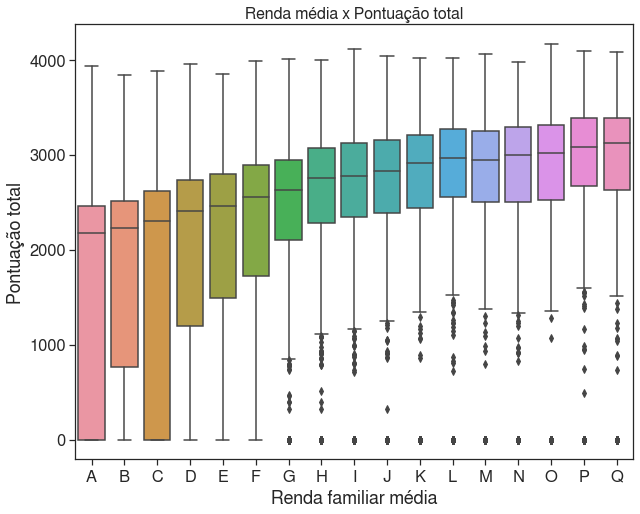

In [15]:
def box_plots(variable1, variable2, title):
    plt.figure(figsize=(10,8))
    sns.boxplot(x=variable1, y=variable2, data=dados, order=renda_ordenada)
    plt.title(title, fontsize=16)

box_plots('Q006', 'NU_NOTA_TOTAL', 'Renda média x Pontuação total')
plt.ylabel('Pontuação total')
plt.xlabel('Renda familiar média');

Algo não está certo... Podemos notar como as primeiras categorias de renda possuem grandes quantidades de zeros.

#### Talvez um histograma nos ajude a entender essa distribuição

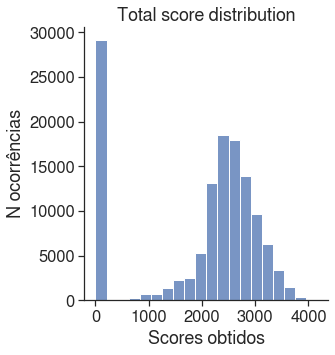

In [16]:
sns.displot(dados, x = 'NU_NOTA_TOTAL', bins=20)
plt.title('Total score distribution')
plt.ylabel('N ocorrências')
plt.xlabel('Scores obtidos')
plt.xticks([0,1000,2000,3000,4000]);

Assim confirmamos que a frequência de notas 0 é bem maior que os outros scores. <br>
Talvez isso se dê por desclassificação dos participantes por faltarem ou serem eliminados das provas;

## Avaliando as notas zero e participantes ausentes

In [17]:
provas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']
dados['NU_NOTA_TOTAL'] = dados[provas].sum(axis=1)
dados.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_TOTAL
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,...,A,A,A,B,A,C,A,B,B,2288.9
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,...,A,A,B,A,A,B,A,A,B,1184.6
2,190001004722,2019,1501402,Belém,15,PA,35,F,2,1,...,A,A,B,A,B,B,A,A,B,2350.5
3,190001004735,2019,1507300,São Félix do Xingu,15,PA,23,F,1,3,...,A,A,B,A,A,B,A,A,B,2555.7
4,190001004776,2019,1500800,Ananindeua,15,PA,16,F,1,3,...,A,A,B,A,A,D,A,A,B,2803.5


In [18]:
provas.append('NU_NOTA_TOTAL')
dados[provas].query('NU_NOTA_TOTAL == 0')

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_TOTAL
10,NaN,NaN,NaN,NaN,NaN,0.0
11,NaN,NaN,NaN,NaN,NaN,0.0
26,NaN,NaN,NaN,NaN,NaN,0.0
38,NaN,NaN,NaN,NaN,NaN,0.0
40,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...
127351,NaN,NaN,NaN,NaN,NaN,0.0
127365,NaN,NaN,NaN,NaN,NaN,0.0
127366,NaN,NaN,NaN,NaN,NaN,0.0
127368,NaN,NaN,NaN,NaN,NaN,0.0


No df acima, notamos como participantes que obtiveram uma nota total de 0, tem valores de NaN nas outras notas.<br>
Qual é a razão desse NaN?

Aqui, criei um novo DF contendo apenas notas totais diferentes de zero

In [19]:
dados_sem_notas_zero = dados.query('NU_NOTA_TOTAL != 0')
dados_sem_notas_zero.head(2)

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_TOTAL
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,...,A,A,A,B,A,C,A,B,B,2288.9
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,...,A,A,B,A,A,B,A,A,B,1184.6


Avaliando o dicionário de dados, notei 4  variáveis (As  variáveis `'TP_PRESENCA_CN'`, `'TP_PRESENCA_CH'`, `'TP_PRESENCA_LC'`, `'TP_PRESENCA_MT'` contém as informação quanto a presença dos alunos) que indicam a presença, ausencia ou eliminação de um participante (1, 0, 2, respectivamente). Assim, agora podemos diferenciar esses subgrupos dos nossos dados.

In [20]:
faltas = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', "TP_PRESENCA_MT"]
dados_faltas = dados[faltas]
print('A quantidade de pessoas que faltaram ou foram eliminadas do teste de CN foi de', len(dados.query('TP_PRESENCA_CN != 1')))

print('A quantidade de pessoas que recebeu NaN como score na nota do teste de CN foi de', dados['NU_NOTA_CN'].isnull().value_counts()[True])

print('A quantidade de pessoas que estavam ausentes na prova de CN foi de', len(dados.query('TP_PRESENCA_CN == 0')))

print('A quantidade de pessoas que foi eliminada do teste de CN foi de ', len(dados.query('TP_PRESENCA_CN == 2')))

print('A quantidade de pessoas que teve um 0 como score na prova de CN foi de', len(dados.query('NU_NOTA_CN == 0')))


A quantidade de pessoas que faltaram ou foram eliminadas do teste de CN foi de 34622
A quantidade de pessoas que recebeu NaN como score na nota do teste de CN foi de 34622
A quantidade de pessoas que estavam ausentes na prova de CN foi de 34570
A quantidade de pessoas que foi eliminada do teste de CN foi de  52
A quantidade de pessoas que teve um 0 como score na prova de CN foi de 18


#### Com as afirmações acima, podemos entender:
1. Valores NaN foram dados para pessoas que estavam ausentes ou foram eliminadas de um teste;
2. Valores de 0 só foram dados à participantes que obtiveram um score de 0 na prova. Nesse caso, o N de 0 realmente é pequeno, já que o participante teria que ter azar de não chutar nenhuma alternativa correta;
3. Notamos que o número de participantes ausentes é bem grande, enquanto o número de zeros é pequeno;

### Existe alguma relação entre ausência nas provas, renda familiar e número de carros?

Criando lista contendo apenas informações relacionas à presença. 

In [21]:
faltas = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']

Primeiro criei uma lista para estratificar os valores da Q010 em 0 (sem carro) e 1 (1 ou mais carros). <br>
Em seguida, adicionei essa lista como nova coluna no dataframe dados

In [22]:
carros = []
for i in dados['Q010']:
    if i == 'A':
        carros.append(0)
    else:
        carros.append(1)
        
dados['Q010_modf'] = carros

Aqui, criei duas variáveis:
1. `faltas_todas_provas` - contendo dados de participantes que faltaram em todas provas;
2. `sem_faltas `         - contendo dados de participantes que não faltaram em nenhuma prova

In [23]:
faltas_todas_provas = dados.query('TP_PRESENCA_CN == 0 & TP_PRESENCA_CH == 0 & TP_PRESENCA_LC == 0 & TP_PRESENCA_MT == 0')

sem_faltas = dados.query('TP_PRESENCA_CN == 1 & TP_PRESENCA_CH == 1 & TP_PRESENCA_LC == 1 & TP_PRESENCA_MT == 1')

print(len(faltas_todas_provas), len(sem_faltas), len(dados), (len(faltas_todas_provas)+ len(sem_faltas)))

28998 92539 127380 121537


In [24]:
renda_ordenada = renda_ordenada = dados['Q006'].unique()
renda_ordenada.sort()

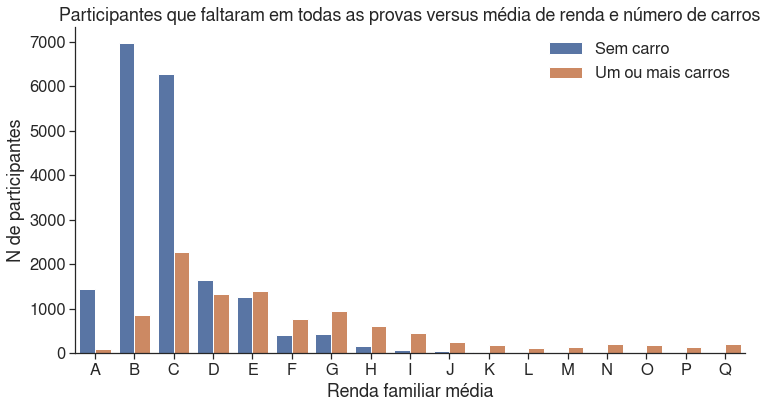

In [25]:
sns.set(style="ticks", font_scale=1.5, font='FreeSans')


plt.figure(figsize=(12,6))
sns.countplot(x='Q006', data=faltas_todas_provas, order=renda_ordenada, hue=dados['Q010_modf'])
plt.title('Participantes que faltaram em todas as provas versus média de renda e número de carros')
plt.xlabel('Renda familiar média')
plt.ylabel('N de participantes')
plt.legend(['Sem carro', 'Um ou mais carros']);
sns.despine()

A figura acima mostra que dos participantes que faltaram em todas as provas, destacam-se os classificados nas três primeiras categorias da renda familiar. Destes, podemos salientar a grande quantidade de participantes que relataram que a família não possui carros. <br>
Apesar de estarmos avaliando apenas uma amostra do dataset completo, possívelmente essa tendência se manteria.

### Será que os participantes que faltaram em um número de provas diferente do total possuem distribuição de renda e número de carros diferente?

Primeiro criei a variável `faltas_menos` em duas etapas, excluindo os índices que correspondiam a participantes não inseridos nas variáveis `faltas_todas_provas` e `sem_faltas`

In [26]:
faltas_menos = dados[~dados.index.isin(sem_faltas.index)]
faltas_menos = faltas_menos[~faltas_menos.index.isin(faltas_todas_provas.index)]

Aqui confirmamos que a quantidade de linhas na nossa variável `falta_menos` está de de acordo com a quantidade obtida ao subtrair o total de dados - (n participantes que faltaram em todas provas + n de participantes que não faltou em nenhuma prova)  

In [27]:
print(len(faltas_menos))
print(len(dados)-(len(faltas_todas_provas)+ len(sem_faltas)))

5843
5843


In [28]:
faltas_menos.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_TOTAL,Q010_modf
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,...,A,B,A,A,B,A,A,B,1184.6,0
62,190001007089,2019,1502400,Castanhal,15,PA,20,F,1,4,...,A,B,A,A,B,A,A,A,1344.5,0
77,190001007653,2019,1503903,Juruti,15,PA,22,F,1,3,...,A,B,A,A,E,A,C,A,0.0,1
100,190001008411,2019,1501402,Belém,15,PA,23,M,1,3,...,A,B,A,A,B,A,A,A,1317.5,0
138,190001009421,2019,1504604,Mocajuba,15,PA,29,F,1,3,...,A,B,A,A,A,A,A,A,1372.0,0


#### Agora, vamos comparar quem faltou em <4 provas e quem faltou em todas

Agrupando dados.

**Obs:** Como o número de participantes que faltou em menos provas do que o total é bem menor do que os que faltaram em todas as provas, vou trabalhar com proporções.

In [29]:
# teste_menos - participante que faltaram em <4 provas

teste_menos = (faltas_menos.groupby('Q006')['Q010_modf']
         .value_counts(normalize=True).rename('porcentagem')
         .mul(100).reset_index().sort_values(['Q006','Q010_modf']))

teste_menos.loc['33'] = ['P', 0, 0]

teste_menos.sort_values(['Q006', 'Q010_modf'], inplace=True)
teste_menos.set_index('Q006', inplace=True)

# teste_todas - participantes que faltaram em todas as provas

teste_todas = (faltas_todas_provas.groupby('Q006')['Q010_modf']
         .value_counts(normalize=True).rename('porcentagem')
         .mul(100).reset_index().sort_values(['Q006','Q010_modf']))

teste_todas.sort_values(['Q006', 'Q010_modf'], inplace=True)
teste_todas.set_index('Q006', inplace=True)

In [30]:
# Filtrando os DFs criados para trabalhar com valores de 'Q010_modf' separados

# Participantes que faltaram em <4 provas
teste_menos_0 = teste_menos[teste_menos['Q010_modf'] == 0]
teste_menos_1 = teste_menos[teste_menos['Q010_modf'] == 1]
teste_menos_0.drop('Q010_modf', axis=1, inplace=True)
teste_menos_1.drop('Q010_modf', axis=1, inplace=True)


# Participantes que faltaram em todas as provas
teste_todas_0 = teste_todas[teste_todas['Q010_modf'] == 0]
teste_todas_1 = teste_todas[teste_todas['Q010_modf'] == 1]
teste_todas_0.drop('Q010_modf', axis=1, inplace=True)
teste_todas_1.drop('Q010_modf', axis=1, inplace=True)

/home/joao-souza/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
# Transformando em Series
teste_menos_0_s = pd.Series(teste_menos_0['porcentagem'])
teste_menos_1_s = pd.Series(teste_menos_1['porcentagem'])

teste_todas_0_s = pd.Series(teste_todas_0['porcentagem'])
teste_todas_1_s = pd.Series(teste_todas_1['porcentagem'])

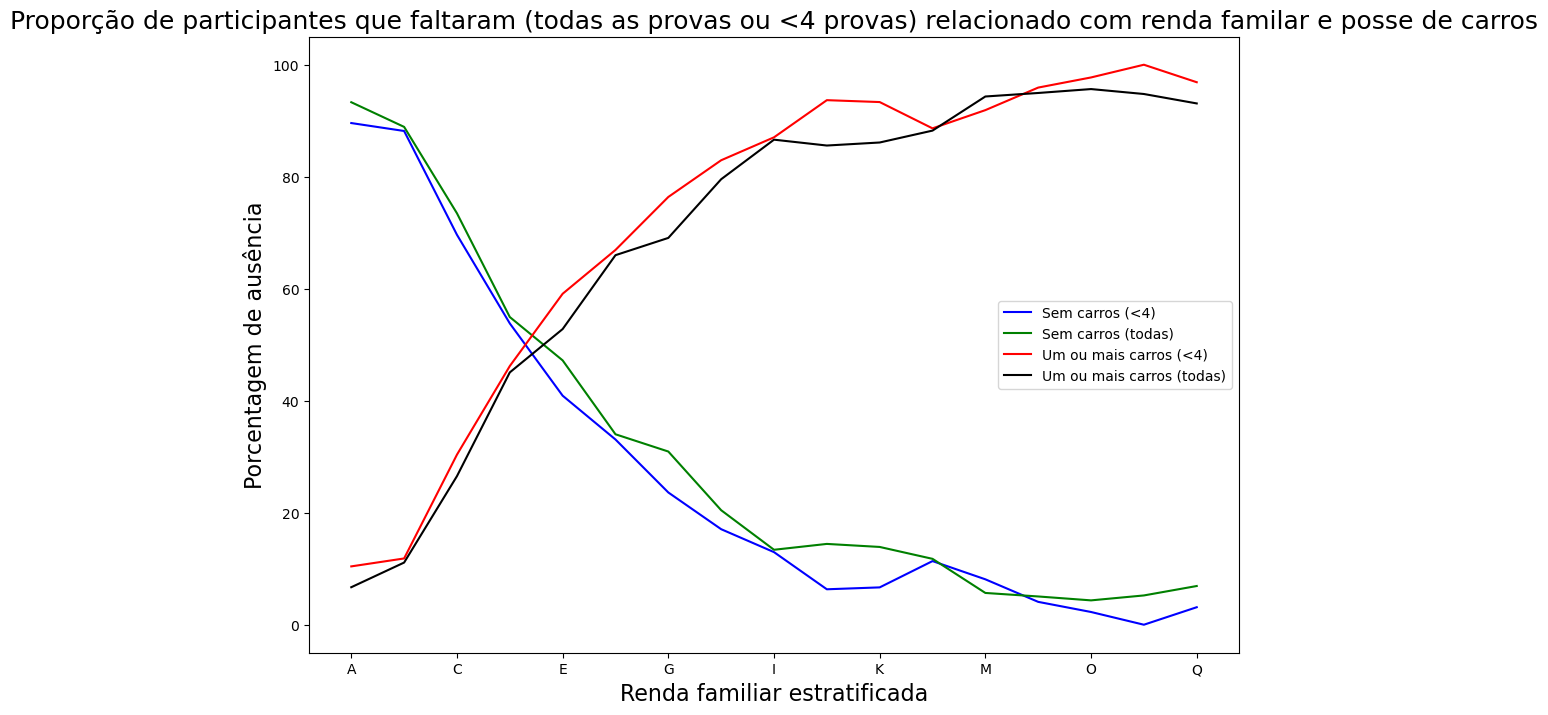

In [32]:
plt.style.use('default')

plt.figure(figsize=(12,8))
plt.title('Proporção de participantes que faltaram (todas as provas ou <4 provas) relacionado com renda familar e posse de carros',
         fontsize=18)
ax1 = teste_menos_0_s.plot(color='blue', label='Sem carros (<4)')
ax2 = teste_todas_0_s.plot(color='green', label='Sem carros (todas)')
ax3 = teste_menos_1_s.plot(color='red', label='Um ou mais carros (<4)')
ax4 = teste_todas_1_s.plot(color='black', label='Um ou mais carros (todas)')
plt.ylabel('Porcentagem de ausência',  fontsize=16)
plt.xlabel('Renda familiar estratificada', fontsize=16)
plt.legend();

No gráfico, plotamos os dados filtrados anteriormente. De modo geral, notamos como a posse de carros influencia bastante na ausência dos participantes nas primeiras categorias de renda familiar. Por outro lado, à medida que as categorias de renda familiar aumentam, a posse de carro não influencia muito na ausência dos participantes.<br>

Possivelmente, os participantes que não possuem carro e são de renda familiar mais baixa teriam que utilizar transporte público ou estavam sujeitos a outros impedimentos, como falta de incentivo pela família, ser necessário cuidar de irmãos ou até ter que trabalhar no dia do ENEM. <br>

Analisando as diferenças entre participantes que faltaram em todas as provas x <4 provas, diferenças sutis podem ser notadas.<br>
Como visto comparando as linhas vermelha e preta (um ou mais carros), há uma maior proporção de participantes que faltaram em <4 provas comparada à propoporção dos que faltaram em todas as provas. <br>
<br>
Dentre outras razões, é possível que participantes que faltaram <4 provas:
1. Tiveram um desempenho ruim no primeiro dia e decidiram não retornar nos outros dias de teste;
2. Passaram por algum imprevisto e não puderam frequentar o teste em 1 dia, decidindo não retornar nos outros dias de teste;

**Obs:** Essa análise foi feita com os dados da amostra. Possivelmente, resultados diferentes seriam observados levando em conta o banco completo.<br>
É importante ressaltar que uma análise estatística seria necessária para confirmar que a diferença observada é significativa.

### Participantes que tem que se locomover de município ou estado para prestar a prova tem maiores índices de ausência?

In [33]:
dif_estado = dados.query('SG_UF_PROVA != SG_UF_RESIDENCIA')
dif_municipio = dados.query('NO_MUNICIPIO_PROVA != NO_MUNICIPIO_RESIDENCIA')
mesmo_municipio = dados.query('NO_MUNICIPIO_PROVA == NO_MUNICIPIO_RESIDENCIA')
print(len(dif_estado), len(dif_municipio))

1222 21596


Com os resultados das 'queries' realizadas acima, vemos que o N participantes que tiveram que mudar de municipio é bem maior do que os que tiveram que mudar de estado.

In [34]:
dif_municipio_faltas_todas = dif_municipio.query('TP_PRESENCA_CN == 0 & TP_PRESENCA_CH == 0 & TP_PRESENCA_LC == 0 & TP_PRESENCA_MT == 0')
mesmo_municipio_faltas_todas = mesmo_municipio.query('TP_PRESENCA_CN == 0 & TP_PRESENCA_CH == 0 & TP_PRESENCA_LC == 0 & TP_PRESENCA_MT == 0')
dif_estado_faltas_todas = dif_estado.query('TP_PRESENCA_CN == 0 & TP_PRESENCA_CH == 0 & TP_PRESENCA_LC == 0 & TP_PRESENCA_MT == 0')

dif_municipio_faltas_todas_porcent = round((len(dif_municipio_faltas_todas) / len(dif_municipio) * 100), 2)
mesmo_municipio_faltas_todas_porcent =  round((len(mesmo_municipio_faltas_todas) / len(mesmo_municipio) * 100), 2)
dif_estado_faltas_todas_porcent = round((len(dif_estado_faltas_todas) / len(dif_estado) * 100), 2)

print('A porcentagem participantes que se ausentaram em todas as provas considerando a necessidade de mudar de município ou estado foi de:')
print(f'1. Para os que NÃO tiveram de mudar de município {mesmo_municipio_faltas_todas_porcent} %')
print(f'2. Para os que tiveram de mudar de município {dif_municipio_faltas_todas_porcent} %')
print(f'3. Para os que tiveram de mudar de estado {dif_estado_faltas_todas_porcent} %')


A porcentagem participantes que se ausentaram em todas as provas considerando a necessidade de mudar de município ou estado foi de:
1. Para os que NÃO tiveram de mudar de município 22.49 %
2. Para os que tiveram de mudar de município 24.09 %
3. Para os que tiveram de mudar de estado 29.54 %


Os 'queries' acima mostram como a ausência em todos os dias de prova está relacionado com a necessidade de locomoção entre cidades e estados para realização do teste. <br>

Uma medida que poderia auxiliar na redução na ausência dos participantes em futuras edições do ENEM, seria o aumento na quantidade de locais para realização de testes.

**Obs:** Possivelmente as porcentagens obtidas aqui serão diferentes das porcentagens usando o dataset completo

### Os estudantes que tiveram que mudar de municipio para realizar a prova tem algum impacto na nota total?

Primeiro fiz algumas alterações no dataframe `dados_sem_notas_zero`, para que os índices fossem 'resetados'.

In [35]:
dados_sem_notas_zero.reset_index(inplace=True)

In [36]:
dados_sem_notas_zero.drop('index', axis=1, inplace=True)

/home/joao-souza/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Em seguida, criei uma lista considerando a veracidade da comparação do `'NO_MUNICIPIO_PROVA' != 'NO_MUNICIPIO_RESIDENCIA'`. <br>
1. Caso os nomes fossem diferentes, atribui o valor de 'Diferente';
2. Caso iguais, o valor de 'Mesmo';

Em seguida, adicionei essa lista como a nova coluna `dif_municipio` no dataframe `dados_sem_nota_zero`

In [37]:
dif_lista = []
for i in range(len(dados_sem_notas_zero)):
    if dados_sem_notas_zero['NO_MUNICIPIO_PROVA'][i] != dados_sem_notas_zero['NO_MUNICIPIO_RESIDENCIA'][i]:
        dif_lista.append('Diferente')
    else:
        dif_lista.append('Mesmo')
dados_sem_notas_zero['dif_municipio'] = dif_lista

<ipython-input-37-33c9b4e33cb6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_sem_notas_zero['dif_municipio'] = dif_lista


In [38]:
dados_sem_notas_zero.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_TOTAL,dif_municipio
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,...,A,A,B,A,C,A,B,B,2288.9,Mesmo
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,...,A,B,A,A,B,A,A,B,1184.6,Mesmo
2,190001004722,2019,1501402,Belém,15,PA,35,F,2,1,...,A,B,A,B,B,A,A,B,2350.5,Mesmo
3,190001004735,2019,1507300,São Félix do Xingu,15,PA,23,F,1,3,...,A,B,A,A,B,A,A,B,2555.7,Mesmo
4,190001004776,2019,1500800,Ananindeua,15,PA,16,F,1,3,...,A,B,A,A,D,A,A,B,2803.5,Mesmo


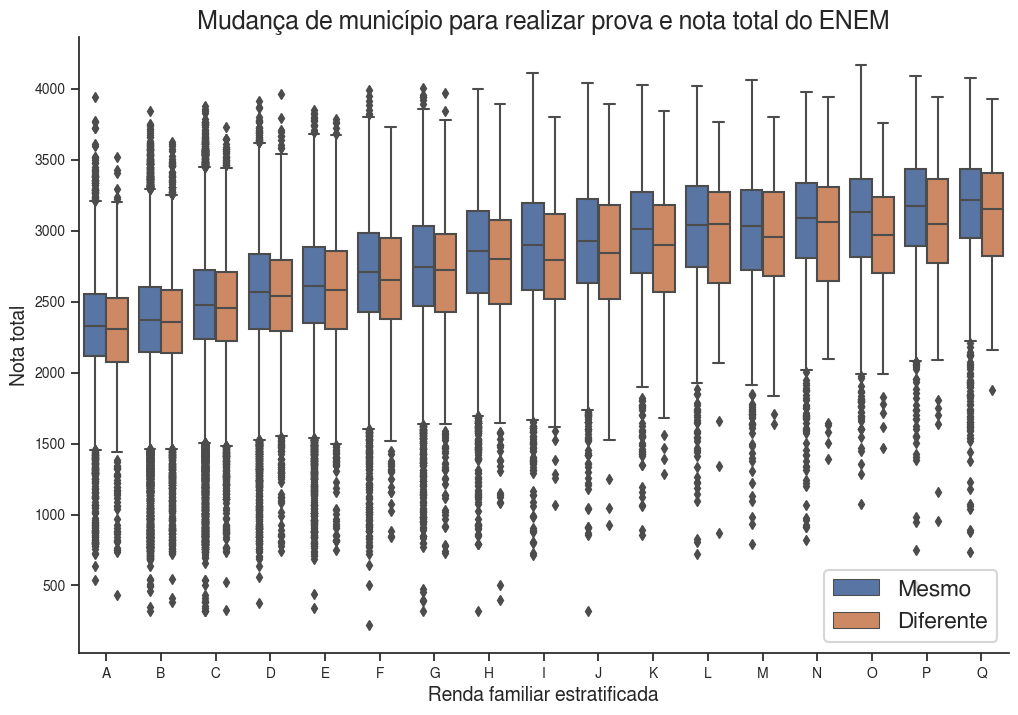

In [39]:
sns.set(style="ticks", font_scale=1.5, font='FreeSans')


plt.figure(figsize=(12,8))
g = sns.boxplot(x='Q006', y='NU_NOTA_TOTAL', data=dados_sem_notas_zero, order=renda_ordenada, hue='dif_municipio')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Nota total', fontsize=14)
plt.xlabel('Renda familiar estratificada', fontsize=14)
sns.despine()
sns.set_context("talk")
plt.title('Mudança de município para realizar prova e nota total do ENEM', fontsize=18);
plt.legend()

No gŕafico acima podemos ver como a necessidade de mudança de município para realizar a prova do ENEM tem relação com a nota total obtida, considerando também a renda familiar.<br>
Algumas explicações (especulativas) sobre esse achado:
1. Possivelmente participantes que tiveram que viajar para fazer a prova podem se cansar durante a viagem, levando à menor atenção durante o exame. Adicionalmente podemos considerar que o participante teria que acordar mais cedo e se preparar com muito mais antecedência para chegar no horário correto;
2. Alternativamente, se os participantes tiveram que viajar, é possível que seu município não tenha escolas ou ainda que isso indique que a qualidade do ensino no município de residência é menor;

**Obs**: Trabalhei com os filtros já excluindo estudantes que tiraram notas zero.

### Será que os estudantes que tiveram que viajar para realizar a prova tem maior frequência em escolas rurais?

In [40]:
dados_sem_notas_zero.groupby(['TP_LOCALIZACAO_ESC', 'dif_municipio']).count()

NU_INSCRICAO  NU_ANO  \
TP_LOCALIZACAO_ESC dif_municipio                         
1.0                Diferente              4248    4248   
                   Mesmo                 19881   19881   
2.0                Diferente               281     281   
                   Mesmo                   558     558   

                                  CO_MUNICIPIO_RESIDENCIA  \
TP_LOCALIZACAO_ESC dif_municipio                            
1.0                Diferente                         4248   
                   Mesmo                            19881   
2.0                Diferente                          281   
                   Mesmo                              558   

                                  NO_MUNICIPIO_RESIDENCIA  CO_UF_RESIDENCIA  \
TP_LOCALIZACAO_ESC dif_municipio                                              
1.0                Diferente                         4248              4248   
                   Mesmo                            19881             19881   
2.0                Diferente                          281               281   
                   Mesmo                              558               558   

                                  SG_UF_RESIDENCIA  NU_IDADE  TP_SEXO  \
TP_LOCALIZACAO_ESC dif_municipio                                        
1.0                Diferente                  4248      4248     4248   
                   Mesmo                     19881     19881    19881   
2.0                Diferente                   281       281      281   
                   Mesmo                       558       558      558   

                                  TP_ESTADO_CIVIL  TP_COR_RACA  ...   Q017  \
TP_LOCALIZACAO_ESC dif_municipio                                ...          
1.0                Diferente                 4248         4248  ...   4248   
                   Mesmo                    19881        19881  ...  19881   
2.0                Diferente                  281          281  ...    281   
                   Mesmo                      558          558  ...    558   

                                   Q018   Q019   Q020   Q021   Q022   Q023  \
TP_LOCALIZACAO_ESC dif_municipio                                             
1.0                Diferente       4248   4248   4248   4248   4248   4248   
                   Mesmo          19881  19881  19881  19881  19881  19881   
2.0                Diferente        281    281    281    281    281    281   
                   Mesmo            558    558    558    558    558    558   

                                   Q024   Q025  NU_NOTA_TOTAL  
TP_LOCALIZACAO_ESC dif_municipio                               
1.0                Diferente       4248   4248           4248  
                   Mesmo          19881  19881          19881  
2.0                Diferente        281    281            281  
                   Mesmo            558    558            558  

[4 rows x 136 columns]

In [41]:
diferente = round((281 / (4248 + 281)) * 100, 2)
mesmo = round((581 / (19881 + 558))* 100, 2)

print('A porcentagem de alunos provenientes de escolas rurais é de:')
print(f'\n1. Considerando participantes que tiveram que viajar para outro município para realizar as provas: {diferente}%')
print(f'2. Considerando participantes que realizaram as provas em seu município de residência: {mesmo}%')

A porcentagem de alunos provenientes de escolas rurais é de:

1. Considerando participantes que tiveram que viajar para outro município para realizar as provas: 6.2%
2. Considerando participantes que realizaram as provas em seu município de residência: 2.84%


Com base nas informações acima, notamos como uma porcentagem maior de estudante que tiveram que viajar para realizar a prova é proveniente de escolas rurais.<br>
**Obs**: Possivelmente esas porcentagens poderiam ser diferentes, se consideramos o dataset completo.

#### E será que estudantes provenientes de escolas rurais tem desempenho menor do que os de escolas urbanas?

In [42]:
dados_sem_notas_zero['TP_LOCALIZACAO_ESC_MODF'] = dados_sem_notas_zero['TP_LOCALIZACAO_ESC']

for i in range(len(dados_sem_notas_zero['TP_LOCALIZACAO_ESC'])):
    if dados_sem_notas_zero['TP_LOCALIZACAO_ESC'][i] == 1.0:
        dados_sem_notas_zero['TP_LOCALIZACAO_ESC_MODF'][i] = 'Urbana'
    else:
        dados_sem_notas_zero['TP_LOCALIZACAO_ESC_MODF'][i] = 'Rural'

<ipython-input-42-ec7b633fc8d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_sem_notas_zero['TP_LOCALIZACAO_ESC_MODF'] = dados_sem_notas_zero['TP_LOCALIZACAO_ESC']
<ipython-input-42-ec7b633fc8d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_sem_notas_zero['TP_LOCALIZACAO_ESC_MODF'][i] = 'Rural'
/home/joao-souza/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

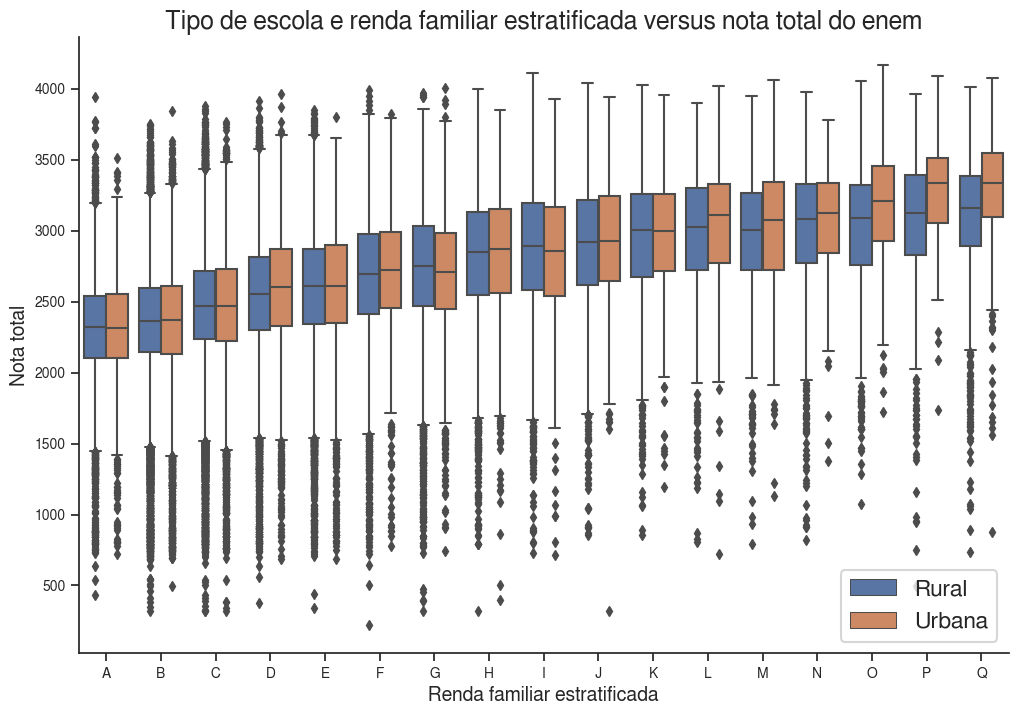

In [43]:
sns.set(style="ticks", font_scale=1.5, font='FreeSans')


plt.figure(figsize=(12,8))
g = sns.boxplot(x='Q006', y='NU_NOTA_TOTAL', data=dados_sem_notas_zero, order=renda_ordenada, hue='TP_LOCALIZACAO_ESC_MODF')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Nota total', fontsize=14)
plt.xlabel('Renda familiar estratificada', fontsize=14)
sns.despine()
sns.set_context("talk")
plt.title('Tipo de escola e renda familiar estratificada versus nota total do enem', fontsize=18);
plt.legend();

Na figura acima observamos que eixstem diferenças sutis na distribuição das notas obtidas por participantes provenientes de escolas rurais e escolas urbanas, porém discretas.<br>
Confesso que eu esperava uma diferença mais significativa. É possível esses resultados sejam diferentes se estívessemos utilizando o banco de dados completos.

## Será que existem diferenças nas notas dos participantes quanto ao sexo?

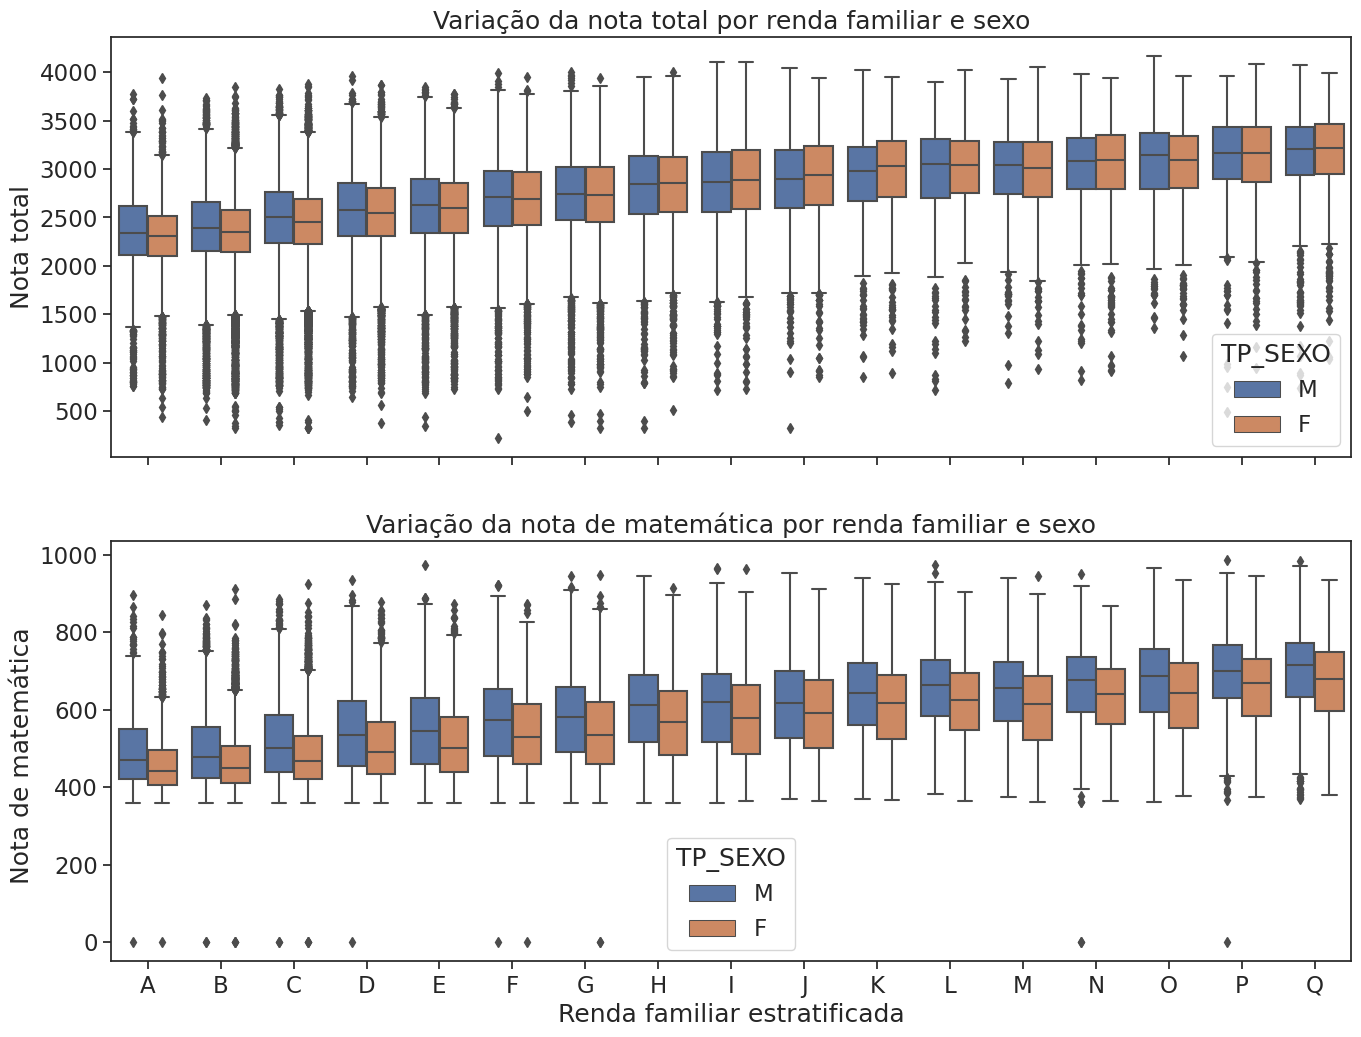

In [44]:
sns.set(style="ticks", font_scale=1.5)

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Notas totais, considerando renda e sexo
sns.boxplot(ax = axes[0], x='Q006', y='NU_NOTA_TOTAL', data=dados_sem_notas_zero, order=renda_ordenada, hue='TP_SEXO')
axes[0].set_ylabel('Nota total')
axes[0].set_xlabel('')
axes[0].set_title('Variação da nota total por renda familiar e sexo', fontsize=18);


# Notas em matemática, cconsiredando renda e sexo
sns.boxplot(ax= axes[1], x='Q006', y='NU_NOTA_MT', data=dados_sem_notas_zero, order=renda_ordenada, hue='TP_SEXO')
axes[1].set_ylabel('Nota de matemática ')
axes[1].set_xlabel('Renda familiar estratificada')
axes[1].set_title('Variação da nota de matemática por renda familiar e sexo', fontsize=18);


Nos gráficos acima vemos como existem diferenças nas notas totais considerando o sexo dos participantes.<br>
Essa diferença é acentuada em participantes das primeiras categorias de renda e tende a ser mais sútil para os participantse classificados com rendas mais altas. <br>
Notavelmente, no segundo gráfico vemos como a nota de matemática se mantém mais alta em participantes do sexo masculino, mesmo nas maiores rendas familiares. <br>
Hipótese: <br>
Historicamente, meninas tem menos apoio dos familiares ou na escola para estudarem disciplinas como matemática, física e etc. Há um stigma social que "matemática não é coisa de menina" ou ainda que "meninas não são boas com matemática", o que são falácias. <br>
[Para saber mais](#women_in_stem)

### Gestantes ou lactentes tem menor nota em relação a sua contraparte?

In [45]:
feminino = dados_sem_notas_zero.query('TP_SEXO == "F"')
feminino.reset_index(inplace=True)
feminino.drop('index', axis = 1, inplace=True)

/home/joao-souza/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
gest_lact = feminino.query('IN_GESTANTE == 1 | IN_LACTANTE == 1')

In [47]:
gest_lact.index

Int64Index([  435,   475,  1162,  1700,  2722,  3460,  4186,  6453,  6629,
             7024,  8329,  9812,  9893,  9944, 10430, 10803, 13456, 16684,
            18702, 20429, 21381, 22170, 22958, 25456, 26015, 26466, 27371,
            27804, 28210, 29269, 32308, 33315, 34559, 37019, 37842, 39091,
            41313, 41879, 42147, 42778, 42971, 44087, 44539, 45220, 45786,
            47772, 48880, 49161, 50554, 50697, 50802, 50996, 52654, 52854,
            53410, 53459, 53791, 55701, 57731],
           dtype='int64')

In [48]:
gest_lact_list = []
for i in gest_lact.index:
    gest_lact_list.append(i)    

In [49]:
feminino['IN_GEST_LACT'] = feminino['IN_GESTANTE']

<ipython-input-49-607760f6a0de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feminino['IN_GEST_LACT'] = feminino['IN_GESTANTE']


In [50]:
for i in gest_lact_list:
    feminino.iloc[i]['IN_GEST_LACT'] == 1

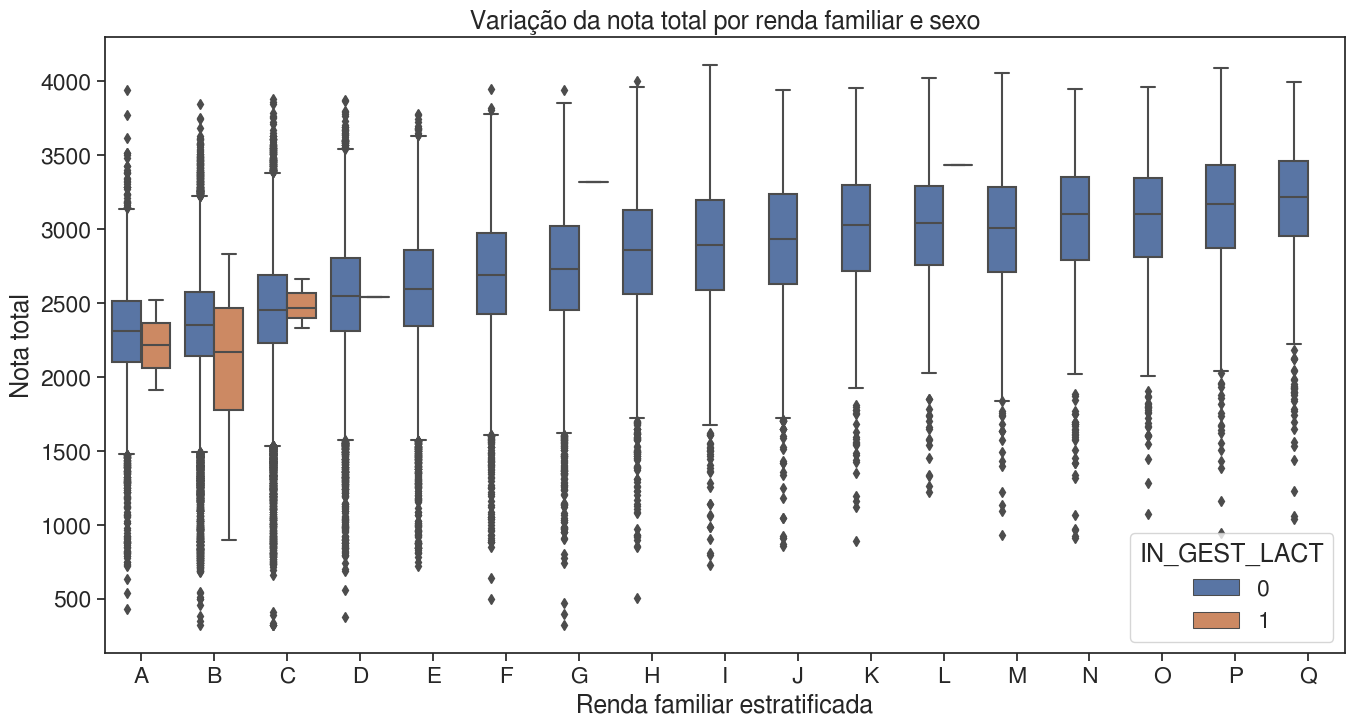

In [66]:
sns.set(style="ticks", font_scale=1.5, font='FreeSans')

plt.figure(figsize=(16, 8))

# Notas totais, considerando renda e sexo
sns.boxplot(x='Q006', y='NU_NOTA_TOTAL', data=feminino, order=renda_ordenada, hue='IN_GEST_LACT')
plt.ylabel('Nota total')
plt.xlabel('Renda familiar estratificada')
plt.title('Variação da nota total por renda familiar e sexo', fontsize=18);


Na figura acima vemos como mulhres que eram gestantes ou lactantes na época da prova do ENEM em 2019 apresentaram notas menores que as outras mulheres. <br>
Notamos ainda, como a incidência de mulheres lactantes ou gestantes é maior nas primerias faixas de renda familiar.<br>
**Obs**: Possivelmente teríamos um padrão diferente ao considerar o banco de dados completo.

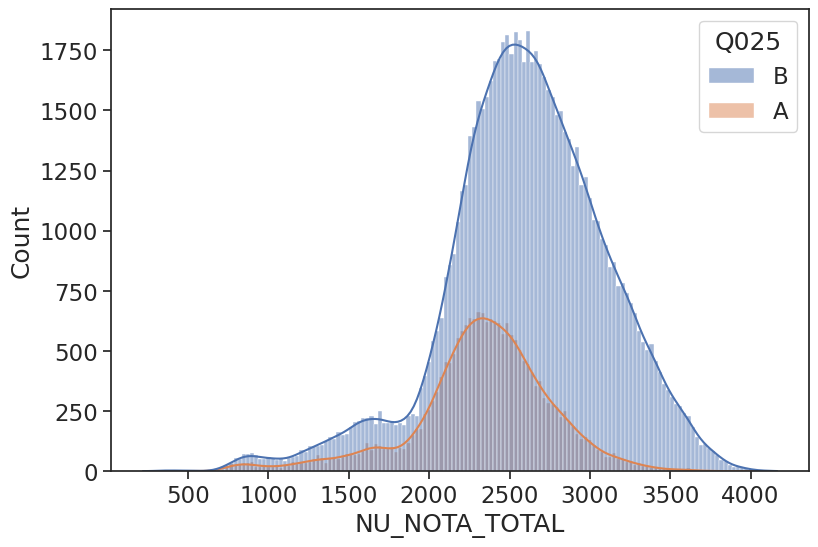

In [52]:
# 11
plt.figure(figsize=(9,6))
sns.histplot(dados_sem_notas_zero, x = 'NU_NOTA_TOTAL', hue='Q025', kde=True);

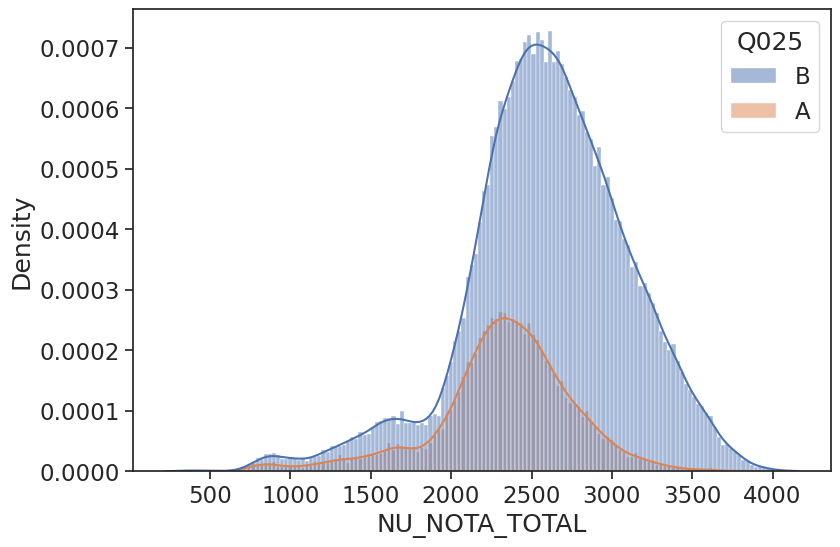

In [53]:
# 11
plt.figure(figsize=(9,6))
sns.histplot(dados_sem_notas_zero, x = 'NU_NOTA_TOTAL', hue='Q025', kde=True, stat='density');

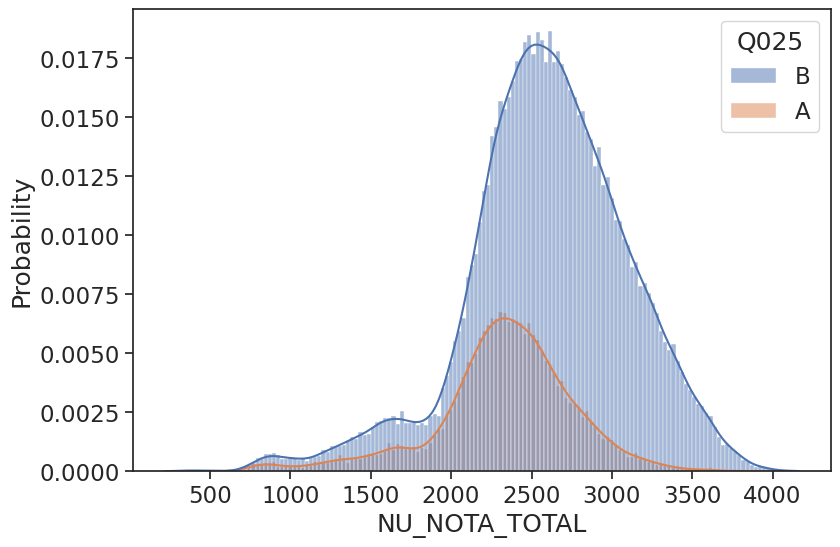

In [54]:
# 11
plt.figure(figsize=(9,6))
sns.histplot(dados_sem_notas_zero, x = 'NU_NOTA_TOTAL', hue='Q025', kde=True, stat='probability');

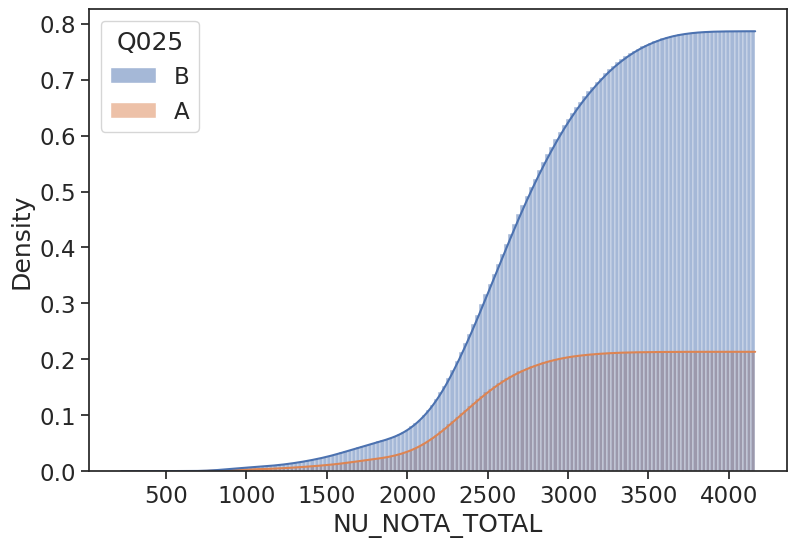

In [55]:
# 11
plt.figure(figsize=(9,6))
sns.histplot(dados_sem_notas_zero, x = 'NU_NOTA_TOTAL', hue='Q025', kde=True, stat='density', cumulative=True);

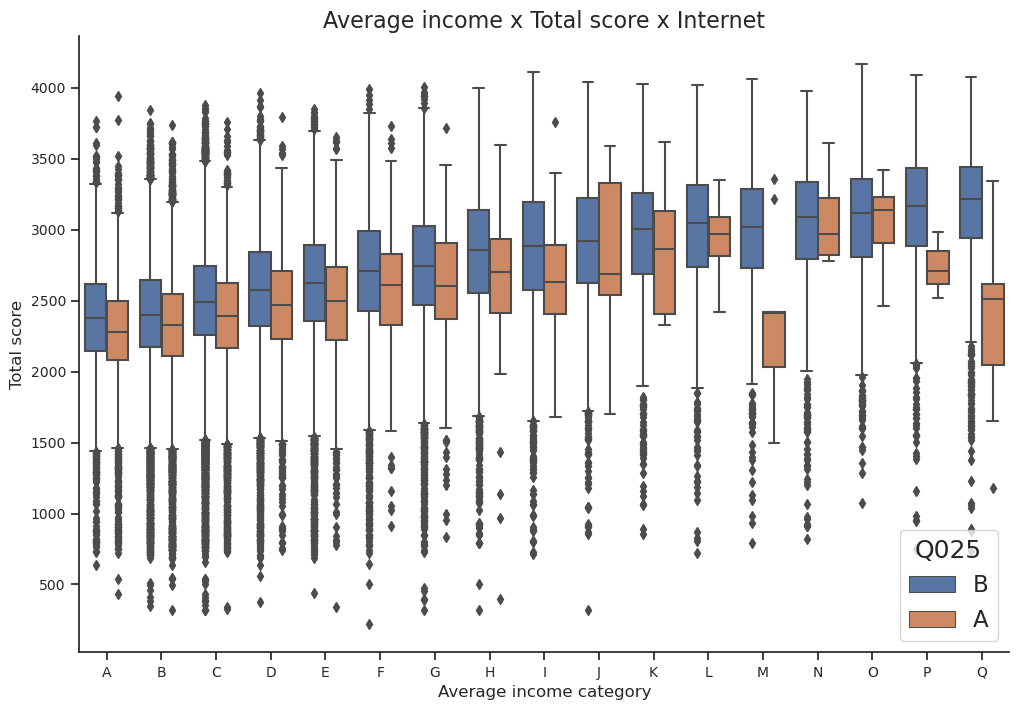

In [56]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Q006', y='NU_NOTA_TOTAL', data=dados_sem_notas_zero, order=renda_ordenada, hue='Q025')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Total score', fontsize=12)
plt.xlabel('Average income category', fontsize=12)
sns.despine()
sns.set_context("talk")
plt.title('Average income x Total score x Internet', fontsize=16);

In [57]:
dados[provas]

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_TOTAL
0,435.6,512.3,432.4,488.6,420.0,2288.9
1,NaN,409.3,NaN,375.3,400.0,1184.6
2,423.2,499.1,427.2,441.0,560.0,2350.5
3,426.2,578.1,499.9,551.5,500.0,2555.7
4,516.5,571.3,424.5,511.2,780.0,2803.5
...,...,...,...,...,...,...
127375,502.4,559.6,539.7,525.7,740.0,2867.4
127376,449.1,380.9,418.2,450.3,520.0,2218.5
127377,NaN,516.0,NaN,497.9,440.0,1453.9
127378,564.7,416.2,455.7,517.3,620.0,2573.9


# Para saber mais

## Paleta de cores
<a id='paleta_de_cores'></a>

1. [Curso de data Visualization da Alura](https://www.alura.com.br/curso-online-data-visualization)
2. [A Better Default Colormap for Matplotlib | SciPy 2015 | Nathaniel Smith and Stéfan van der Walt](https://www.youtube.com/watch?v=xAoljeRJ3lU)
3. [Color in Data Visualization: Less How, More Why](https://towardsdatascience.com/color-in-data-visualization-less-how-more-why-348514a3c4d8)


## Mulheres nas exatas
[The stem gap](https://www.aauw.org/resources/research/the-stem-gap/)

<a id='women_in_stem'></a>